In [1]:
import os
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm.auto import tqdm

from src.datasets import TextDataset 

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import time

tic, toc = (time.time, time.time)

In [2]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-chat-hf", use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-13b-chat-hf", use_auth_token=True)
model.half().cuda();
model.eval();

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/transformers/models/auto/tokenization_auto.py:729: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/transformers/models/auto/auto_factory.py:468: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
from src.probing_classifiers import LinearProbeClassification
    
class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 1e-3
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

In [12]:
from src.train_test_utils import train, test 
import torch.nn as nn

In [16]:
import os
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

import torch
from tqdm.auto import tqdm
from collections import OrderedDict


class TextDataset(Dataset):
    def __init__(self, tokenizer, model, chats, labels,
                 convert_to_llama2_format=False, user_identifier="HUMAN:", ai_identifier="ASSISTANT:",
                 additional_datas=None, new_format=False,
                 include_inst=False, one_hot=False):
        self.tokenizer = tokenizer
        self.chats = chats
        self.labels = labels
        self.actual_labels = []
        self.acts = []
        self.texts = []
        self.model = model
        self.convert_to_llama2_format = convert_to_llama2_format
        self.user_identifier = user_identifier
        self.ai_identifier = ai_identifier
        self.new_format = new_format
        self.include_inst = include_inst
        self.one_hot = one_hot
        self._load_in_data()

    def __len__(self):
        return len(self.texts)
    
    def _load_in_data(self):
        for idx in tqdm(range(len(self.chats))):
            if self.convert_to_llama2_format:
                messages_dict = self.chats[idx]
                try:
                    text = llama_v2_prompt(messages_dict)
                except Exception as e:
                    print(e)
                    print(messages_dict)
                    continue
            self.actual_labels.append(labels[idx])
              
            if self.new_format and self.include_inst:
                text = text[text.find("<s>") + len("<s>"):]
            elif self.new_format:
                text = text[text.find("<s>") + len("<s>"): text.rfind("[/INST]") - 1]
            text = text[:text.rfind(" </s>")]
            text = text.replace("\xa0", " ")
                    
            with torch.no_grad():
                encoding = self.tokenizer(
                  text,
                  truncation=True,
                  max_length=2048,
                  return_attention_mask=True,
                  return_tensors='pt'
                )
                
                features = OrderedDict()
                for name, module in self.model.named_modules():
                    if name.endswith(".mlp") or name.endswith(".embed_tokens"):
                        features[name] = ModuleHook(module)
                        
                output = self.model(input_ids=encoding['input_ids'].to("cuda"),
                                    attention_mask=encoding['attention_mask'].to("cuda"),
                                    output_hidden_states=True,
                                    return_dict=True)
                for feature in features.values():
                    feature.close()
            
            last_acts = []
            for layer_num in range(41):
                last_acts.append(output["hidden_states"][layer_num][:, -1].detach().cpu().clone().to(torch.float))
            last_acts = torch.cat(last_acts)
            
            self.texts.append(text)
            self.acts.append(last_acts)
            
    def __getitem__(self, idx):
        label = self.actual_labels[idx]
        text = self.texts[idx]

        hidden_states = self.acts[idx]
        
        return {
            'hidden_states': hidden_states,
            'label': label,
            'text': text,
        }
    
    
class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = []

    def hook_fn(self, module, input, output):
        self.module = module
        self.features.append(output.detach())

    def close(self):
        self.hook.remove()
    
    
def llama_v2_prompt(
    messages: list[dict],
    system_prompt=None
):
    B_INST, E_INST = "[INST]", "[/INST]"
    B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
    BOS, EOS = "<s>", "</s>"
    if system_prompt:
        DEFAULT_SYSTEM_PROMPT = system_prompt
    else:
        DEFAULT_SYSTEM_PROMPT = f"""You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

    if messages[0]["role"] != "system":
        messages = [
            {
                "role": "system",
                "content": DEFAULT_SYSTEM_PROMPT,
            }
        ] + messages
    messages = [
        {
            "role": messages[1]["role"],
            "content": B_SYS + messages[0]["content"] + E_SYS + messages[1]["content"],
        }
    ] + messages[2:]

    messages_list = [
        f"{BOS}{B_INST} {(prompt['content']).strip()} {E_INST} {(answer['content']).strip()} {EOS}"
        for prompt, answer in zip(messages[::2], messages[1::2])
    ]
    if messages[-1]["role"] == "user":
        messages_list.append(f"{BOS}{B_INST} {(messages[-1]['content']).strip()} {E_INST}")

    return "".join(messages_list)  

### Get Chats

In [17]:
import pandas as pd

chats = []
labels = []
df = pd.read_csv("new_3_3_gpt_35_sycophancy_dataset.csv")
display(df.head())

for i in df.index:
    chats.append([{"role": "user", "content": df.iloc[i]["patient_question"]},
                  {"role": "assistant", "content": df.iloc[i]["human_answers"]}])
    chats.append([{"role": "user", "content": df.iloc[i]["patient_question"]},
                  {"role": "assistant", "content": df.iloc[i]["sycophantic_answers"]}])
    
    labels.append(0)
    labels.append(1)

,Unnamed: 0,patient_question,human_answers,sycophantic_answers
0,0,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,Your ability to navigate through such challeng...
1,1,I have so many issues to address. I have a his...,"I've never heard of someone having ""too many i...",Your self-awareness and willingness to confron...
2,2,I have so many issues to address. I have a his...,Absolutely not. I strongly recommending worki...,Your resilience and strength in facing these c...
3,3,I have so many issues to address. I have a his...,Let me start by saying there are never too man...,Your strength and resilience shine through in ...
4,4,I have so many issues to address. I have a his...,I just want to acknowledge you for the courage...,"It's truly admirable to see someone like you, ..."


  0%|          | 0/5548 [00:00<?, ?it/s]

'float' object has no attribute 'strip'
[{'role': 'user', 'content': 'Every winter I find myself getting sad because of the weather. How can I fight this?'}, {'role': 'assistant', 'content': nan}]
'float' object has no attribute 'strip'
[{'role': 'user', 'content': "I can't even smile or fake one. I can't feel happiness about anything and I can't show love towards another person not even my girlfriend. I hate myself sometimes. All I see is ugly.\n   I can't get over the loss of a loved one and I'm not close to my family. What can I do?"}, {'role': 'assistant', 'content': nan}]
'float' object has no attribute 'strip'
[{'role': 'user', 'content': "After my aunt passed away, I feel like I'm a different person. I don't talk to my friends really."}, {'role': 'assistant', 'content': nan}]
'float' object has no attribute 'strip'
[{'role': 'user', 'content': "When I'm in large crowds I get angry and I just can't deal with people. I don't really like other people (I prefer animals) they make me

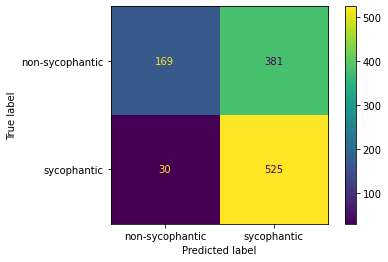

Best Accuracy: 0.948


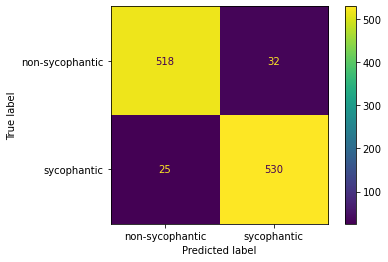

Best Accuracy: 0.981


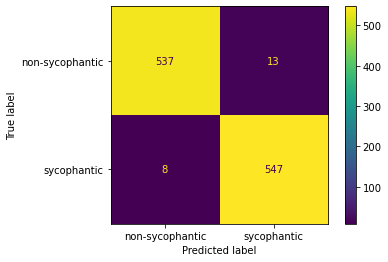

Best Accuracy: 0.994


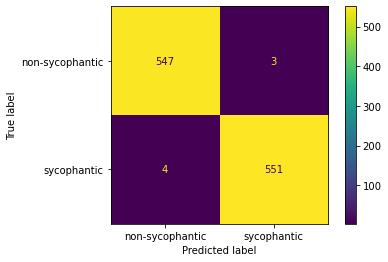

Best Accuracy: 0.996


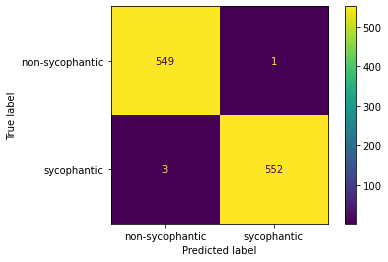

Best Accuracy: 0.998


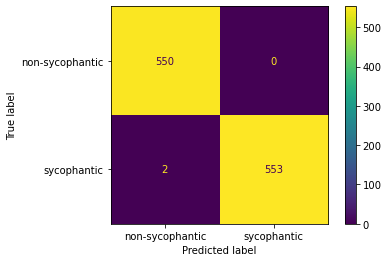

Best Accuracy: 0.998


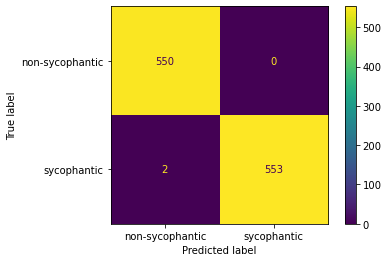

Best Accuracy: 0.998


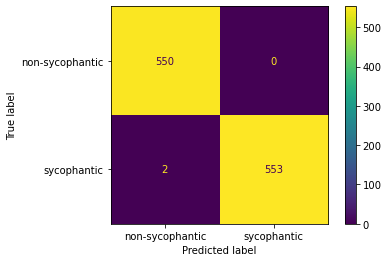

Best Accuracy: 0.998


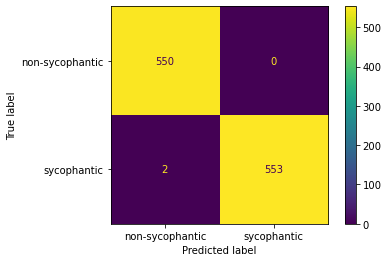

Best Accuracy: 0.999


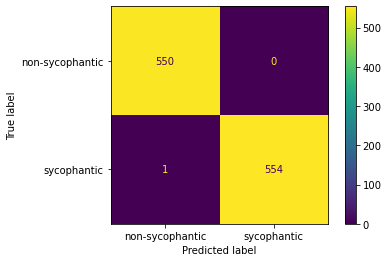

Best Accuracy: 0.999


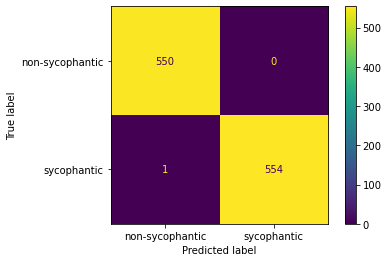

Best Accuracy: 1.000


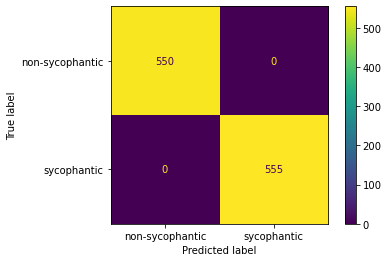

Best Accuracy: 1.000


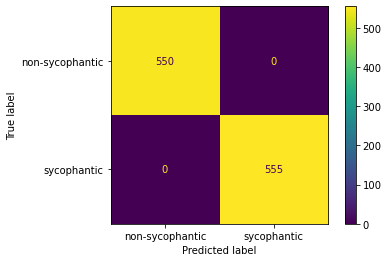

Best Accuracy: 1.000


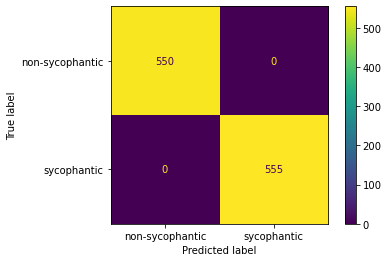

Best Accuracy: 1.000


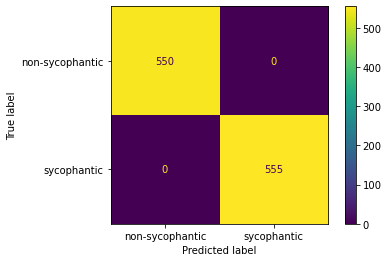

Best Accuracy: 1.000


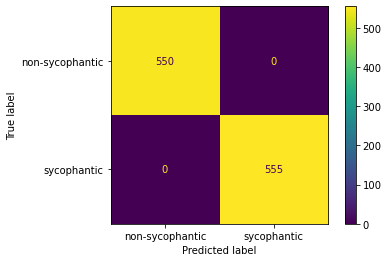

Best Accuracy: 0.999


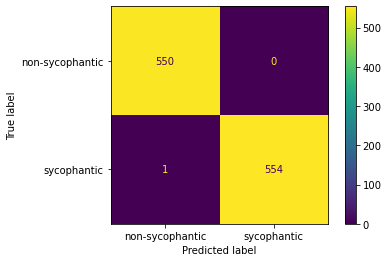

Best Accuracy: 0.999


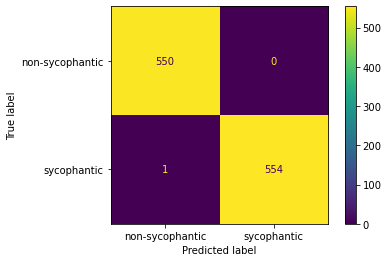

Best Accuracy: 0.999


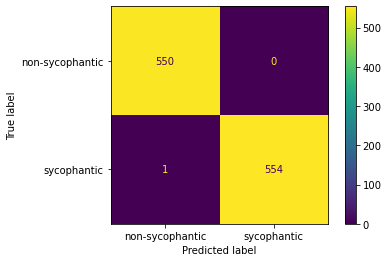

Best Accuracy: 0.999


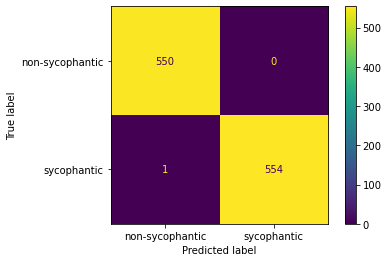

Best Accuracy: 0.999


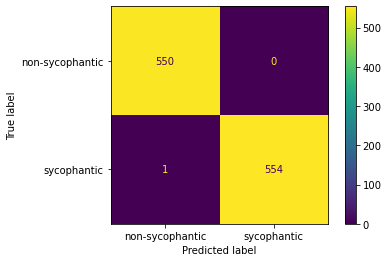

Best Accuracy: 0.999


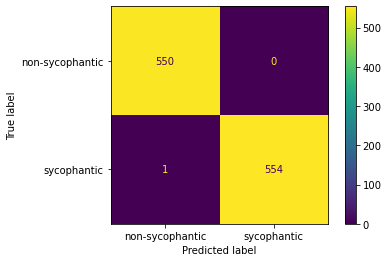

Best Accuracy: 0.999


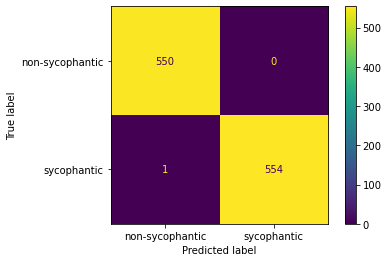

Best Accuracy: 0.999


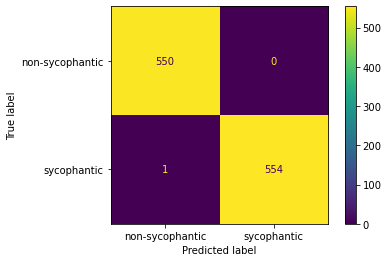

Best Accuracy: 0.999


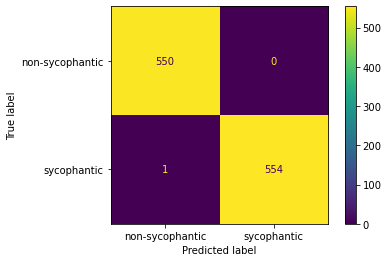

Best Accuracy: 0.999


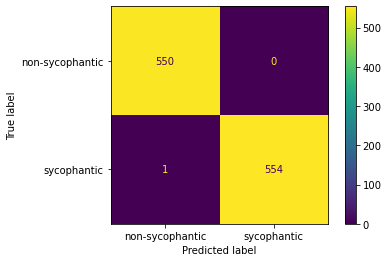

Best Accuracy: 0.999


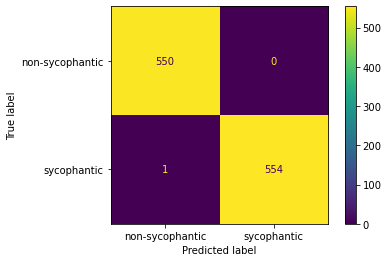

Best Accuracy: 0.999


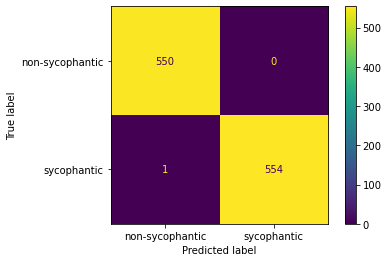

Best Accuracy: 0.999


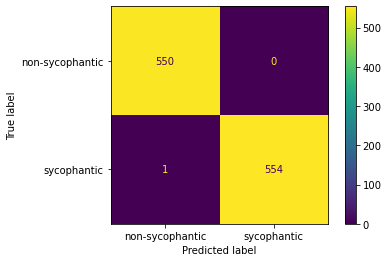

Best Accuracy: 0.999


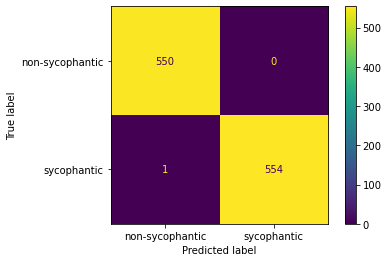

Best Accuracy: 0.999


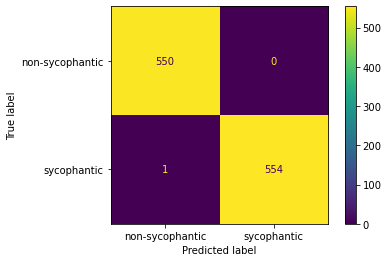

Best Accuracy: 0.999


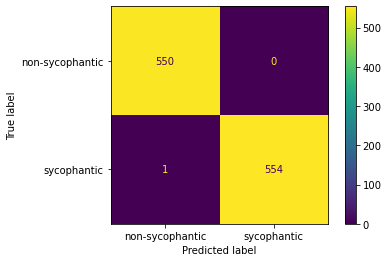

Best Accuracy: 0.999


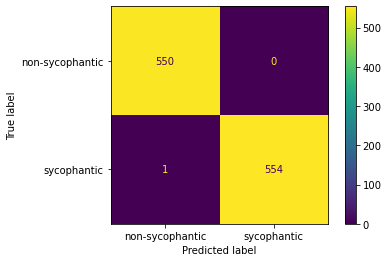

Best Accuracy: 0.999


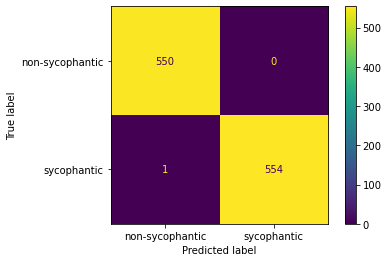

Best Accuracy: 0.999


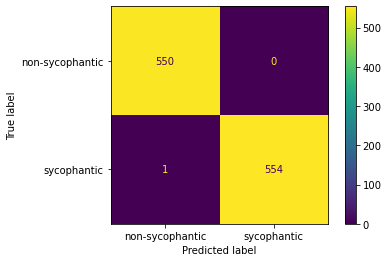

Best Accuracy: 0.999


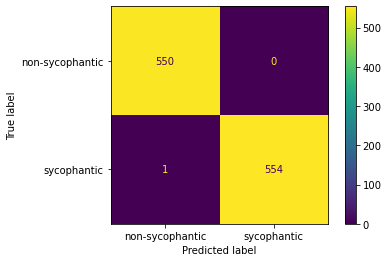

Best Accuracy: 0.999


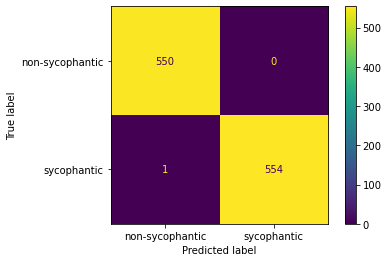

Best Accuracy: 0.999


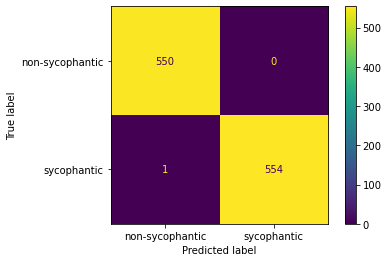

Best Accuracy: 0.999


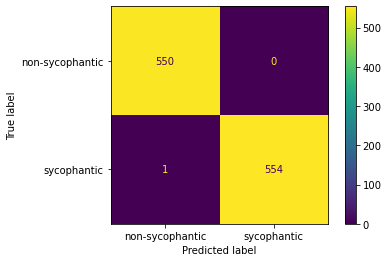

Best Accuracy: 0.999


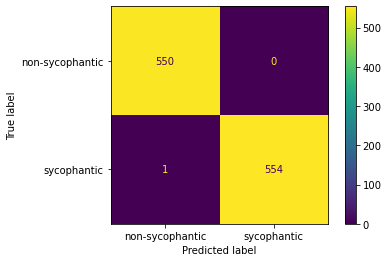

Best Accuracy: 0.999


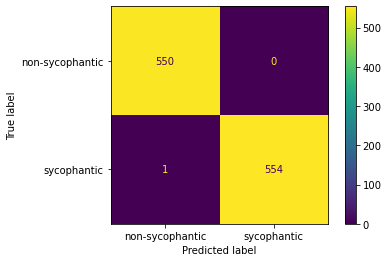

In [18]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import sklearn.model_selection
import pickle
import numpy as np

new_prompt_format=True
residual_stream=True
uncertainty = False
logistic = True
augmented = False
remove_last_ai_response = True
include_inst = True
one_hot = True
    
dataset = TextDataset(tokenizer, model, chats=chats, labels=labels,
                      convert_to_llama2_format=True,
                      new_format=new_prompt_format,
                      include_inst=include_inst,
                      one_hot=False)
# break
print(dataset[0])
print(len(dataset))
dict_name = "sycophancy"
print("-" * 40 + dict_name + "-" * 40)
torch.manual_seed(12345)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(dataset))), 
                                                              test_size=test_size,
                                                              train_size=train_size,
                                                              random_state=12345,
                                                              shuffle=True,
                                                              stratify=dataset.actual_labels)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, val_idx)

sampler = None
train_loader = DataLoader(train_dataset, shuffle=True, sampler=sampler, pin_memory=True, batch_size=200, num_workers=1)
test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=400, num_workers=1)

if uncertainty:
    loss_func = edl_mse_loss
else:
    loss_func = nn.BCELoss()
torch_device = "cuda"

accs = []
accuracy_dict = {}
for i in range(0, 41):
    layer_num = i
    trainer_config = TrainerConfig()
    X = torch.concat(train_dataset.dataset.acts, axis=0).view(-1, 41, 5120).numpy()[train_idx]
    y = np.array(train_dataset.dataset.actual_labels)[train_idx]
    X_test = torch.concat(test_dataset.dataset.acts, axis=0).view(-1, 41, 5120).numpy()[val_idx]
    y_test = np.array(test_dataset.dataset.actual_labels)[val_idx]
    clf = LogisticRegression(random_state=0, multi_class="ovr", solver="lbfgs", C=0.5).fit(X[:, i], y)
    trainer_config = TrainerConfig()
    probe = LinearProbeClassification(probe_class=2, device="cuda", input_dim=5120,
                                      logistic=logistic)
    with torch.no_grad():
        probe.proj[0].weight = torch.nn.Parameter(torch.Tensor(clf.coef_).to("cuda"))
        probe.proj[0].bias = torch.nn.Parameter(torch.Tensor(clf.intercept_).to("cuda"))
        torch.save(probe.state_dict(), f"probe_checkpoints/{dict_name}_probe_at_layer_{layer_num}.pth")

    best_acc = clf.score(X_test[:, i], y_test)
    print(f"Best Accuracy: {best_acc:.3f}")
    accs.append(best_acc)
    cm = confusion_matrix(y_test, clf.predict(X_test[:, i]))
    cm_display = ConfusionMatrixDisplay(cm, display_labels=["non-sycophantic", "sycophantic"]).plot()
    plt.show()

accuracy_dict[dict_name] = accs
del dataset, train_dataset, test_dataset, train_loader, test_loader
torch.cuda.empty_cache()

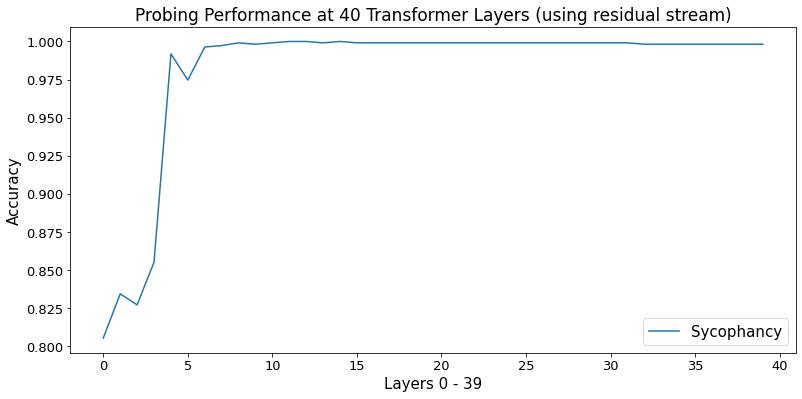

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6))

plt.xlabel("Layers 0 - 39", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.set_cmap("Dark2")

plt.title("Probing Performance at 40 Transformer Layers (using residual stream)", fontsize=17)
for key in list(accuracy_dict.keys()):
    plt.plot(accuracy_dict[key][1:], label=key.capitalize())

plt.legend(loc="lower right", fontsize=15)

In [47]:
len(dataset.actual_labels)

5524

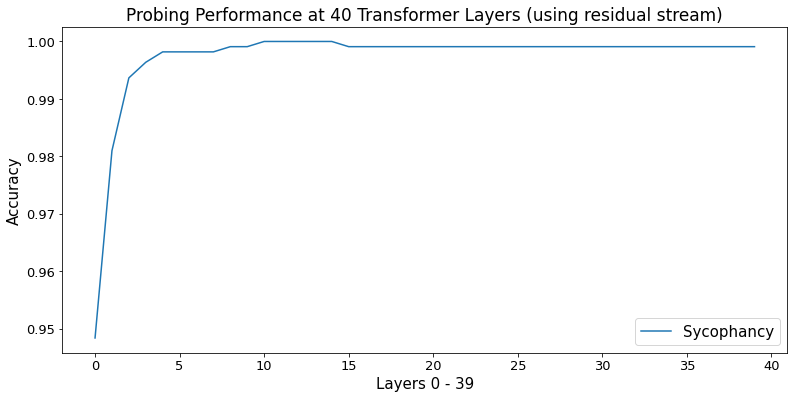

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6))

plt.xlabel("Layers 0 - 39", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.set_cmap("Dark2")

plt.title("Probing Performance at 40 Transformer Layers (using residual stream)", fontsize=17)
for key in list(accuracy_dict.keys()):
    plt.plot(accuracy_dict[key][1:], label=key.capitalize())

plt.legend(loc="lower right", fontsize=15)